In [1]:
import pandas as pd

train =pd.read_csv('/content/train_data_highkappa.csv')
train.head()

,Unnamed: 0,Sentence,Target
0,659,Appellant had stated to the officers that she ...,Invalid
1,3456,We shall discuss the facts more fully in conne...,Others
2,2043,"â€œPerjury is a false statement, either writte...",Invalid
3,3344,The offense is felony theft by false pretext; ...,Issue
4,3231,Numerous contentions urging the commission of ...,Issue


In [2]:
train['Target']=train['Target'].replace(['Rule/Law/holding'],'Rule/Law/Holding')
train['Target']=train['Target'].replace(['Others'],'Invalid')
train['Target'].unique()

array(['Invalid', 'Issue', 'Analysis', 'Facts', 'Conclusion',
       'Rule/Law/Holding'], dtype=object)

Class=3, n=475 (16.096%)
Class=4, n=190 (6.438%)
Class=0, n=439 (14.876%)
Class=2, n=1510 (51.169%)
Class=1, n=147 (4.981%)
Class=5, n=190 (6.438%)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


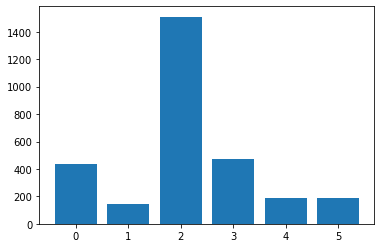

In [3]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
data = train.values


# split into input and output elements
X, y = data[:, :-1], data[:, -1]
# label encode the target variable
y = LabelEncoder().fit_transform(y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [4]:
#cleaning
import nltk
import re
import string
nltk.download('stopwords')
nltk.download('wordnet')
stopword=nltk.corpus.stopwords.words('english')
from nltk.stem import WordNetLemmatizer
wl= WordNetLemmatizer()

def clean_text(text):
  text="".join([word.lower() for word in text if word not in string.punctuation])
  tokens = re.split('\W+',text)
  text = [wl.lemmatize(word) for word in tokens if word not in stopword]
  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer = clean_text)
X_tfidf = tfidf_vect.fit_transform(train['Sentence'])
print(X_tfidf.shape)

(2951, 5835)


In [6]:
from sklearn.externals import joblib
joblib.dump(tfidf_vect, '/content/tf_idf.pkl')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['/content/tf_idf.pkl']

In [7]:
X_tfidf_df=pd.DataFrame(X_tfidf.toarray())
X_tfidf_df.columns=tfidf_vect.get_feature_names()
X_tfidf_df.head()

,,015,1,10,100,1000,10000,100000,10000000,1008,1008a,101,1013,1015,1026,104,1044,105,1065,107,107c,1081,1084,1097,10a,11,110,1102,1116,112,113,1130,113637,114073,115,1150,1161,1183,1185,1191,...,œstarted,œstraight,œsuccessively,œswayingâ,œswollenâ,œtesting,œtestâ,œthat,œthatâ,œthe,œthere,œthey,œthick,œthis,œto,œtwo,œtwoâ,œunlawfully,œunlawfullyâ,œupon,œvagrancyâ,œvalue,œvery,œvisited,œwaived,œwalked,œwas,œwater,œwe,œwell,œwhat,œwhen,œwhere,œwhile,œwhoever,œwilfullyâ,œwillfullyâ,œyesâ,œyou,œyour
0,0.133931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
X = X_tfidf_df
y = train['Target']
# from imblearn.over_sampling import SMOTE
# oversample = SMOTE(random_state=777,k_neighbors=5)
# X, y = oversample.fit_resample(X_tfidf_df, train['Target'])
# # summarize distribution
# counter = Counter(y)
# for k,v in counter.items():
# 	per = v / len(y) * 100
# 	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# # plot the distribution
# pyplot.bar(counter.keys(), counter.values())
# pyplot.show()

In [11]:
#using smote and stochastic gradient boosting
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


X_train, x_test, Y_train, y_test = train_test_split(X,y,test_size=0.27,random_state=2)
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, Y_train)
pred_sgd = sgd.predict(x_test)
print('Accuracy %s' % accuracy_score(pred_sgd,y_test))
print(classification_report(y_test,pred_sgd))

Accuracy 0.6311166875784191
                  precision    recall  f1-score   support

        Analysis       0.49      0.46      0.47       123
      Conclusion       0.47      0.43      0.45        35
           Facts       0.75      0.86      0.80       403
         Invalid       0.50      0.44      0.47       132
           Issue       0.45      0.25      0.32        56
Rule/Law/Holding       0.37      0.31      0.34        48

        accuracy                           0.63       797
       macro avg       0.50      0.46      0.47       797
    weighted avg       0.61      0.63      0.62       797



In [12]:
unlabel = pd.read_csv(r'/content/test_data.csv')
unlabel.head()

,Unnamed: 0,Sentence,Target
0,2173,Darden Sr. testified â€œI saw he was staggerin...,Facts
1,466,Additional moral justification may have been d...,Analysis
2,525,"85, 22 S.W. 140, wherein the accused was actin...",Rule/Law/Holding
3,2199,Under a proper instruction from the court on m...,Facts
4,79,He is eligible for leaves to renew contacts wi...,Facts


In [13]:
# del unlabel['Complete']

In [14]:
del unlabel['Unnamed: 0']

In [15]:
unlabel = unlabel.rename(columns={'Sentence':'text'})
unlabel.head()

,text,Target
0,Darden Sr. testified â€œI saw he was staggerin...,Facts
1,Additional moral justification may have been d...,Analysis
2,"85, 22 S.W. 140, wherein the accused was actin...",Rule/Law/Holding
3,Under a proper instruction from the court on m...,Facts
4,He is eligible for leaves to renew contacts wi...,Facts


In [16]:
unlabel['text'] = unlabel['text'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
unlabel['text'] = unlabel['text'].str.replace('[^\w\s]','')
from nltk.corpus import stopwords
words = stopwords.words('english')
unlabel['text'] = unlabel['text'].apply(lambda x: " ".join(x for x in x.split() if x not in words))


In [17]:
from textblob import TextBlob
from textblob import Word
nltk.download('wordnet')
nltk.download('punkt')
unlabel['text'] = unlabel['text'].apply(lambda x: TextBlob(x).words)
unlabel['text'] = unlabel['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
unlabel.head()

,text,Target
0,darden sr testified âœi saw staggering â prett...,Facts
1,additional moral justification may due complai...,Analysis
2,85 22 sw 140 wherein accused acting upon advic...,Rule/Law/Holding
3,proper instruction court murder malice murder ...,Facts
4,eligible leaf renew contact family,Facts


In [19]:
len(unlabel)

521

In [20]:
unlabel_1 = unlabel.loc[:100]
print("length of unlabel_1",len(unlabel_1))
unlabel_2 = unlabel.loc[100:200]
print("length of unlabel_2",len(unlabel_2))
unlabel_3 = unlabel.loc[200:300]
print("length of unlabel_3",len(unlabel_3))
unlabel_4 = unlabel.loc[300:400]
print("length of unlabel_4",len(unlabel_4))
unlabel_5 = unlabel.loc[400:521]
print("length of unlabel_5",len(unlabel_5))

length of unlabel_1 101
length of unlabel_2 101
length of unlabel_3 101
length of unlabel_4 101
length of unlabel_5 121


In [21]:
x_un1 = tfidf_vect.transform(unlabel_1['text'])


In [22]:
x_un1.shape

(101, 5835)

In [23]:
pred_unlabel_1 = sgd.predict(x_un1)

In [24]:
unlabel_1['Target']=pred_unlabel_1
unlabel_1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,Target
0,darden sr testified âœi saw staggering â prett...,Facts
1,additional moral justification may due complai...,Facts
2,85 22 sw 140 wherein accused acting upon advic...,Invalid
3,proper instruction court murder malice murder ...,Facts
4,eligible leaf renew contact family,Facts


In [25]:
train = train.rename(columns={'Sentence':'text'})
del train['Unnamed: 0']
train.head()

,text,Target
0,Appellant had stated to the officers that she ...,Invalid
1,We shall discuss the facts more fully in conne...,Invalid
2,"â€œPerjury is a false statement, either writte...",Invalid
3,The offense is felony theft by false pretext; ...,Issue
4,Numerous contentions urging the commission of ...,Issue


In [26]:
frame_1 = [train,unlabel_1]
train_1 = pd.concat(frame_1)
len(train_1)

3052

In [27]:
x_train_1 = tfidf_vect.transform(train_1['text'])
x_train_1.shape

(3052, 5835)

In [36]:
X = x_train_1
y =  train_1['Target']
# X, y = oversample.fit_resample(x_train_1, train_1['Target'])
X_train, x_test, Y_train, y_test = train_test_split(X,y,test_size=0.27,random_state=2)
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, Y_train)
pred_sgd = sgd.predict(x_test)
print('Accuracy %s' % accuracy_score(pred_sgd,y_test))
print(classification_report(y_test,pred_sgd))

Accuracy 0.6642424242424242
                  precision    recall  f1-score   support

        Analysis       0.50      0.50      0.50       125
      Conclusion       0.66      0.47      0.55        45
           Facts       0.75      0.88      0.81       420
         Invalid       0.57      0.48      0.52       141
           Issue       0.61      0.39      0.47        49
Rule/Law/Holding       0.36      0.20      0.26        45

        accuracy                           0.66       825
       macro avg       0.57      0.49      0.52       825
    weighted avg       0.65      0.66      0.65       825



In [37]:
x_un2 = tfidf_vect.transform(unlabel_2['text'])
x_un2.shape

(101, 5835)

In [38]:
pred_unlabel_2 = sgd.predict(x_un2)

In [39]:
unlabel_2['Target']=pred_unlabel_2
unlabel_2.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,Target
100,notice relator case set trial county court nov...,Facts
101,examination occurred night middle may testifie...,Facts
102,undisputed testimony reflects appellant drivin...,Facts
103,appellant testify offer evidence behalf,Facts
104,56 uniform act regulating traffic highway gist...,Facts


In [40]:
frame_2 = [train_1,unlabel_2]
train_2 = pd.concat(frame_2)
len(train_2)

3153

In [41]:
x_train_2 = tfidf_vect.transform(train_2['text'])
x_train_2.shape

(3153, 5835)

In [42]:
X = x_train_2
y =  train_2['Target']
# X, y = oversample.fit_resample(x_train_2, train_2['Target'])
X_train, x_test, Y_train, y_test = train_test_split(X,y,test_size=0.27,random_state=2)
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, Y_train)
pred_sgd = sgd.predict(x_test)
print('Accuracy %s' % accuracy_score(pred_sgd,y_test))
print(classification_report(y_test,pred_sgd))

Accuracy 0.6267605633802817
                  precision    recall  f1-score   support

        Analysis       0.48      0.44      0.46       133
      Conclusion       0.62      0.46      0.53        39
           Facts       0.72      0.86      0.79       420
         Invalid       0.46      0.43      0.45       152
           Issue       0.55      0.31      0.40        54
Rule/Law/Holding       0.47      0.28      0.35        54

        accuracy                           0.63       852
       macro avg       0.55      0.46      0.49       852
    weighted avg       0.61      0.63      0.61       852



In [43]:
x_un3 = tfidf_vect.transform(unlabel_3['text'])
x_un3.shape

(101, 5835)

In [44]:
pred_unlabel_3 = sgd.predict(x_un3)

In [45]:
unlabel_3['Target']=pred_unlabel_3
unlabel_3.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,Target
200,second customer left appellant returned make p...,Issue
201,find evidence amply sufficient sustain juryâs ...,Analysis
202,action show thatâ,Analysis
203,certification attending physician shown filed ...,Facts
204,testified agent bland first left automobile wa...,Facts


In [46]:
frame_3 = [train_2,unlabel_3]
train_3 = pd.concat(frame_3)
len(train_3)

3254

In [47]:
x_train_3 = tfidf_vect.transform(train_3['text'])
x_train_3.shape

(3254, 5835)

In [48]:
X = x_train_3
y =  train_3['Target']
# X, y = oversample.fit_resample(x_train_3, train_3['Target'])
X_train, x_test, Y_train, y_test = train_test_split(X,y,test_size=0.27,random_state=2)
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, Y_train)
pred_sgd = sgd.predict(x_test)
print('Accuracy %s' % accuracy_score(pred_sgd,y_test))
print(classification_report(y_test,pred_sgd))

Accuracy 0.6632536973833902
                  precision    recall  f1-score   support

        Analysis       0.51      0.52      0.51       128
      Conclusion       0.57      0.41      0.48        39
           Facts       0.76      0.87      0.81       464
         Invalid       0.51      0.38      0.44       156
           Issue       0.61      0.47      0.53        49
Rule/Law/Holding       0.39      0.35      0.37        43

        accuracy                           0.66       879
       macro avg       0.56      0.50      0.52       879
    weighted avg       0.65      0.66      0.65       879



In [49]:
x_un4 = tfidf_vect.transform(unlabel_4['text'])
x_un4.shape


(101, 5835)

In [50]:
pred_unlabel_4 = sgd.predict(x_un4)
unlabel_4['Target']=pred_unlabel_4
unlabel_4.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,text,Target
300,provision caption nothing election code shall ...,Analysis
301,section 6 pl,Invalid
302,amended answer appellant alleged bond invalid ...,Analysis
303,evidence sufficient support conviction appella...,Analysis
304,case cited note 19,Invalid


In [51]:
frame_4 = [train_3,unlabel_4]
train_4 = pd.concat(frame_4)
len(train_4)

3355

In [52]:
x_train_4 = tfidf_vect.transform(train_4['text'])
x_train_4.shape

(3355, 5835)

In [53]:
X = x_train_4
y =  train_4['Target']
# X, y = oversample.fit_resample(x_train_4, train_4['Target'])
X_train, x_test, Y_train, y_test = train_test_split(X,y,test_size=0.27,random_state=2)
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, Y_train)
pred_sgd = sgd.predict(x_test)
print('Accuracy %s' % accuracy_score(pred_sgd,y_test))
print(classification_report(y_test,pred_sgd))

Accuracy 0.6799116997792495
                  precision    recall  f1-score   support

        Analysis       0.53      0.49      0.51       143
      Conclusion       0.51      0.44      0.47        41
           Facts       0.79      0.87      0.83       473
         Invalid       0.56      0.51      0.54       148
           Issue       0.56      0.43      0.49        51
Rule/Law/Holding       0.45      0.34      0.39        50

        accuracy                           0.68       906
       macro avg       0.57      0.51      0.54       906
    weighted avg       0.66      0.68      0.67       906



In [54]:
x_un5 = tfidf_vect.transform(unlabel_5['text'])
x_un5.shape

(121, 5835)

In [55]:
pred_unlabel_5 = sgd.predict(x_un5)
unlabel_5['Target']=pred_unlabel_5
unlabel_5.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,text,Target
400,application affidavit admitted court âœfor wha...,Facts
401,overrule appellantâs contention court erred pe...,Conclusion
402,state regarded authority case,Analysis
403,testimony adduced appellant mother lillie mae ...,Facts
404,appellant needle mark inside left elbow,Facts


In [56]:
frame_5 = [train_4,unlabel_5]
train_5 = pd.concat(frame_5)
len(train_5)

3476

In [57]:
x_train_5 = tfidf_vect.transform(train_5['text'])
x_train_5.shape

(3476, 5835)

In [58]:
X = x_train_5
y =  train_5['Target']
# X, y = oversample.fit_resample(x_train_5, train_5['Target'])
X_train, x_test, Y_train, y_test = train_test_split(X,y,test_size=0.27,random_state=2)
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, Y_train)
pred_sgd = sgd.predict(x_test)
print('Accuracy %s' % accuracy_score(pred_sgd,y_test))
print(classification_report(y_test,pred_sgd))

Accuracy 0.678381256656017
                  precision    recall  f1-score   support

        Analysis       0.58      0.48      0.53       156
      Conclusion       0.65      0.49      0.56        45
           Facts       0.75      0.89      0.81       480
         Invalid       0.57      0.50      0.53       148
           Issue       0.56      0.43      0.48        56
Rule/Law/Holding       0.44      0.31      0.37        54

        accuracy                           0.68       939
       macro avg       0.59      0.52      0.55       939
    weighted avg       0.66      0.68      0.66       939



In [59]:
# df = pd.read_csv('/content/test_data.csv')

# df['Target']=df['Target'].replace(['Rule/Law/holding'],'Rule/Law/Holding')
# df['Target']=df['Target'].replace(['Others'],'Invalid')

# df['Sentence'] = df['Sentence'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
# df['Sentence'] = df['Sentence'].str.replace('[^\w\s]','')
# from nltk.corpus import stopwords
# words = stopwords.words('english')
# df['Sentence'] = df['Sentence'].apply(lambda x: " ".join(x for x in x.split() if x not in words))

# from textblob import TextBlob
# from textblob import Word
# nltk.download('wordnet')
# nltk.download('punkt')
# df['Sentence'] = df['Sentence'].apply(lambda x: TextBlob(x).words)
# df['Sentence'] = df['Sentence'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x]))

# final_test = tfidf_vect.transform(df['Sentence'])

# pred_sgd_final = sgd.predict(final_test)
# print('Accuracy %s' % accuracy_score(pred_sgd_final,df['Target']))
# print(classification_report(df['Target'],pred_sgd_final))